In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные выплаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [2]:
data = pd.read_csv('vehicle_insurance.csv')

data

Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0       Male   44                1         28.0                   0   
1       Male   76                1          3.0                   0   
2       Male   47                1         28.0                   0   
3       Male   21                1         11.0                   1   
4     Female   29                1         41.0                   1   
...      ...  ...              ...          ...                 ...   
9995  Female   24                1         37.0                   1   
9996    Male   28                1         35.0                   1   
9997  Female   27                1         15.0                   0   
9998  Female   28                1         14.0                   1   
9999  Female   25                1         45.0                   1   

     Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0      > 2 Years            Yes         40454.0                  26.0   
1       1-2 Year             No         33536.0                  26.0   
2      > 2 Years            Yes         38294.0                  26.0   
3       < 1 Year             No         28619.0                 152.0   
4       < 1 Year             No         27496.0                 152.0   
...          ...            ...             ...                   ...   
9995    < 1 Year             No         21243.0                 152.0   
9996    < 1 Year             No         23589.0                 160.0   
9997    < 1 Year            Yes         33340.0                 152.0   
9998    < 1 Year             No         25426.0                 152.0   
9999    < 1 Year             No         18843.0                 152.0   

      Vintage  Response  
0         217         1  
1         183         0  
2          27         1  
3         203         0  
4          39         0  
...       ...       ...  
9995       21         0  
9996      173         0  
9997      207         0  
9998      247         0  
9999      131         0  

[10000 rows x 11 columns]

In [3]:
data_catboost = data.copy()

**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

# EDA

### Посмотрим на матрицу корреляций и нарисуем график

In [4]:
data.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [5]:
num_col = data.loc[:,data.dtypes!='object'].columns

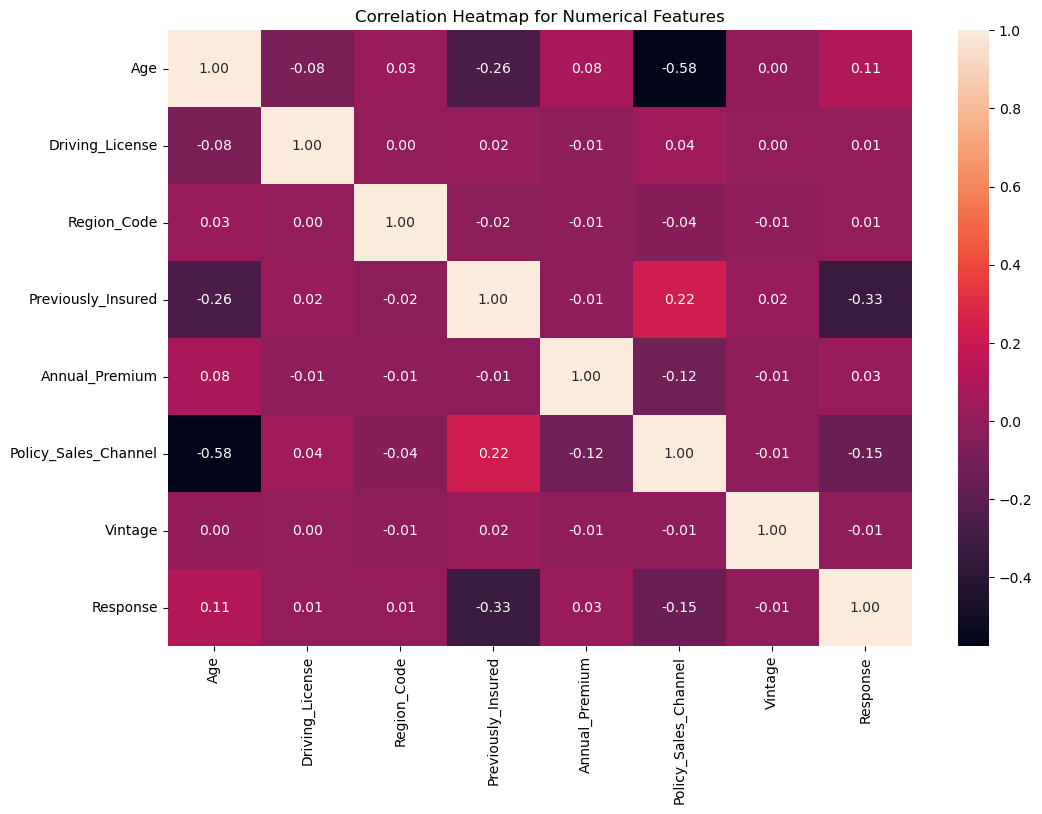

In [6]:
corr_matrix = data[num_col].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cbar=True)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

### Посмотрим на распределение колонок

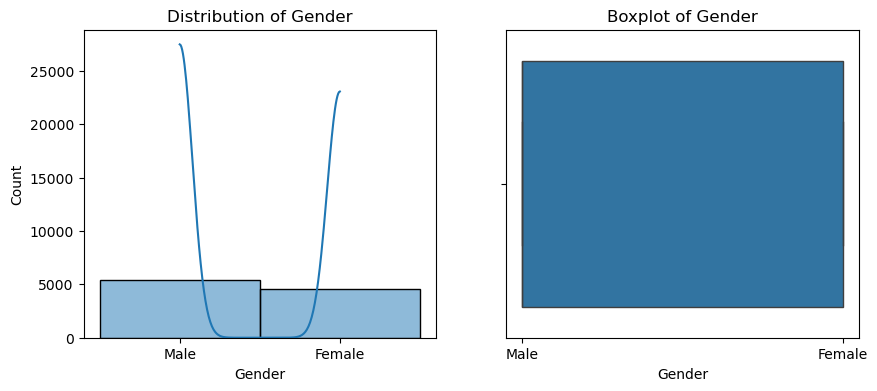

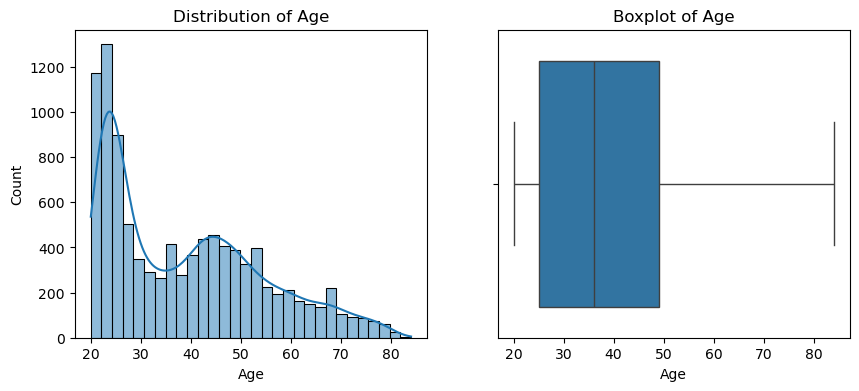

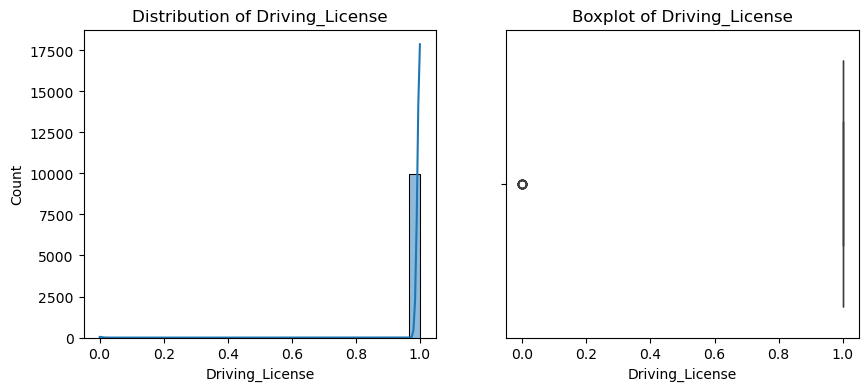

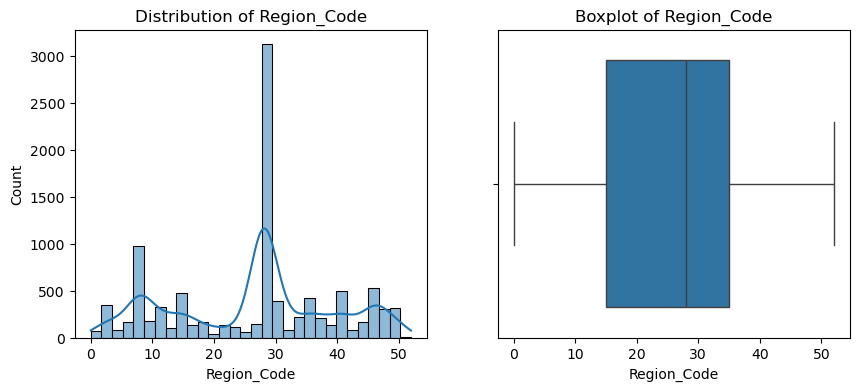

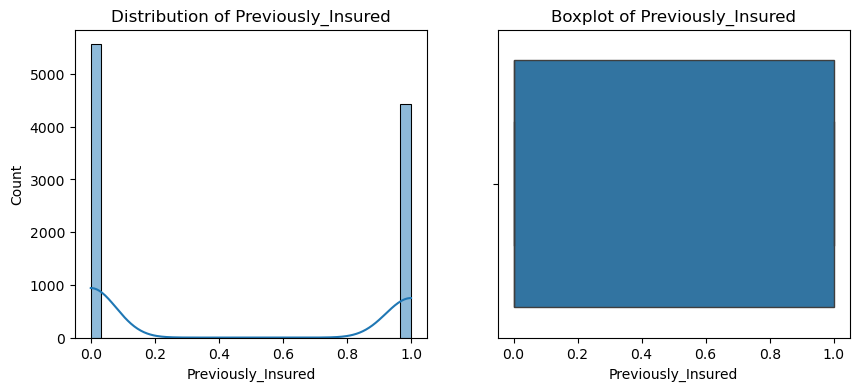

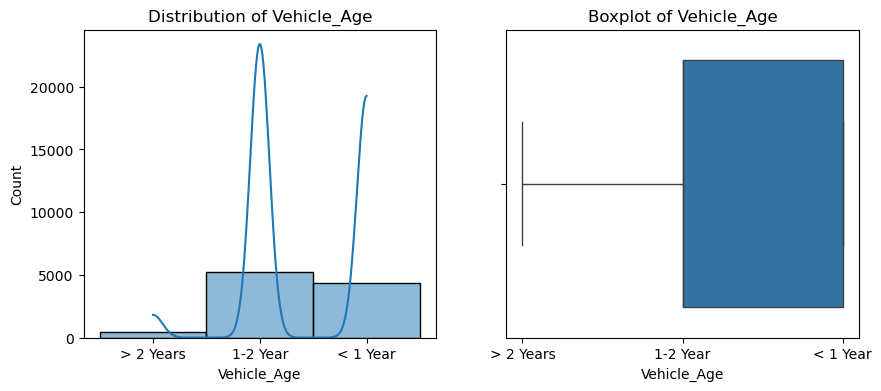

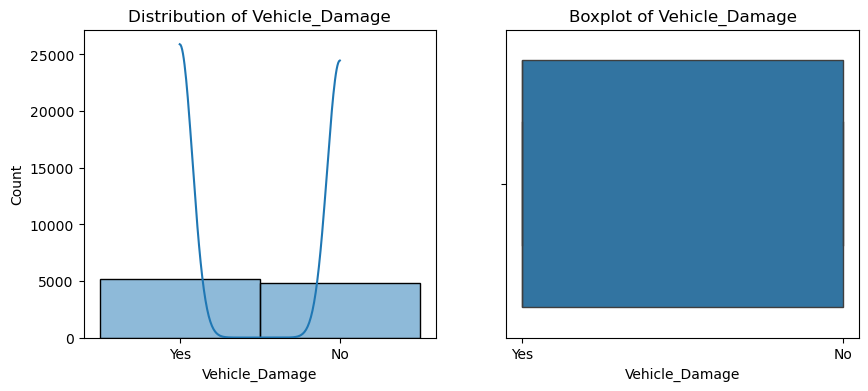

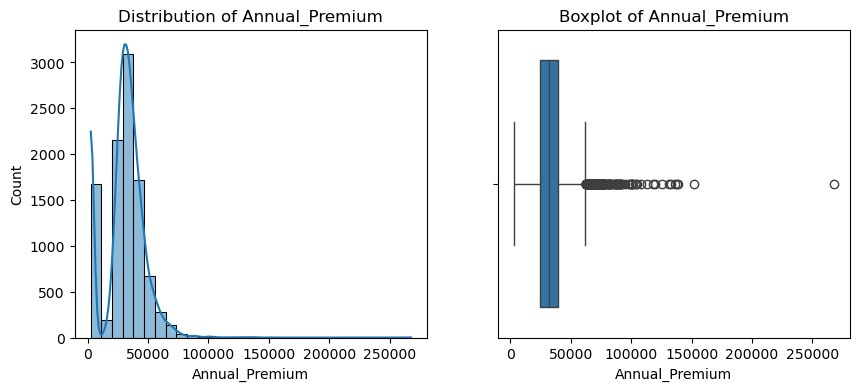

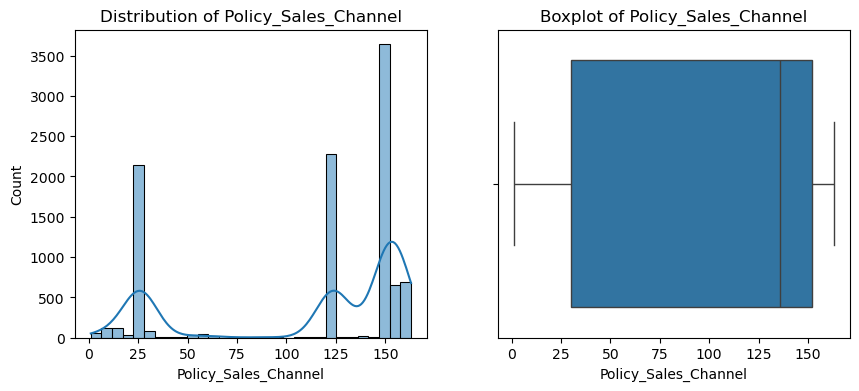

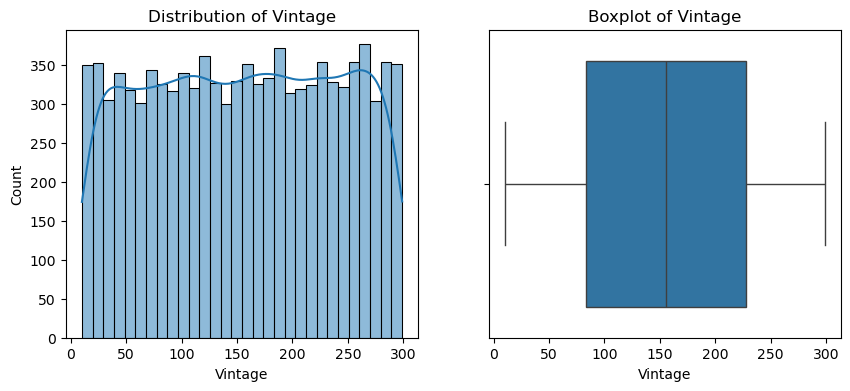

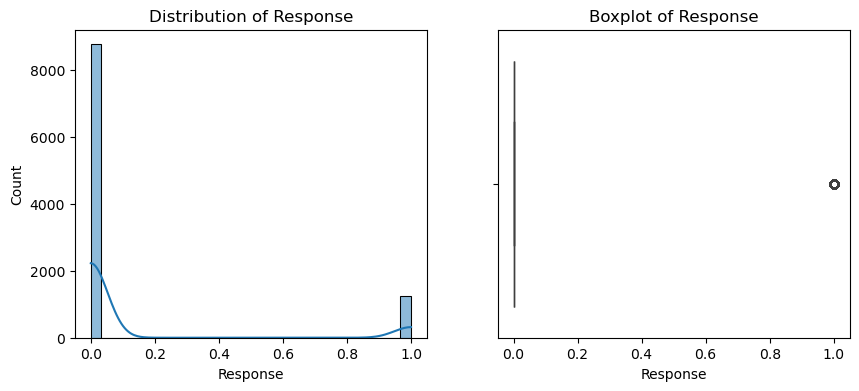

In [7]:
columns_to_plot = data.columns  
for col in columns_to_plot:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

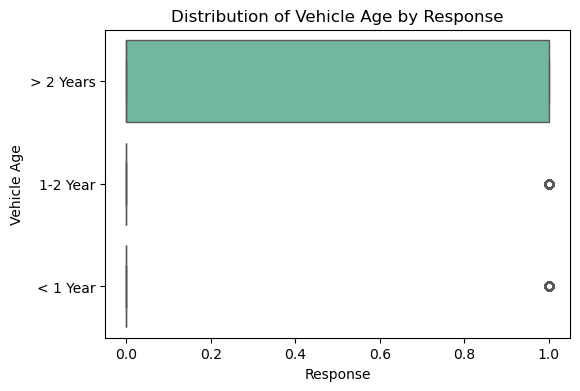

In [8]:
# Распределение возраста транспортного средства в зависимости от Response
plt.figure(figsize=(6, 4))
sns.boxplot(data=data, x='Response', y='Vehicle_Age', palette='Set2')
plt.title('Distribution of Vehicle Age by Response')
plt.xlabel('Response')
plt.ylabel('Vehicle Age')
plt.show()


In [9]:
categorical_columns = data.select_dtypes(include=['object']).columns
print("Категориальные столбцы:", categorical_columns)

cat_ohe_df = pd.get_dummies(data[categorical_columns], drop_first=True, dtype=int)

data = data.drop(columns=categorical_columns)

data = pd.concat([data, cat_ohe_df], axis=1)
print(data)

Категориальные столбцы: Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
      Age  Driving_License  Region_Code  Previously_Insured  Annual_Premium  \
0      44                1         28.0                   0         40454.0   
1      76                1          3.0                   0         33536.0   
2      47                1         28.0                   0         38294.0   
3      21                1         11.0                   1         28619.0   
4      29                1         41.0                   1         27496.0   
...   ...              ...          ...                 ...             ...   
9995   24                1         37.0                   1         21243.0   
9996   28                1         35.0                   1         23589.0   
9997   27                1         15.0                   0         33340.0   
9998   28                1         14.0                   1         25426.0   
9999   25                1         45.0 

In [10]:
data.dtypes

Age                        int64
Driving_License            int64
Region_Code              float64
Previously_Insured         int64
Annual_Premium           float64
Policy_Sales_Channel     float64
Vintage                    int64
Response                   int64
Gender_Male                int64
Vehicle_Age_< 1 Year       int64
Vehicle_Age_> 2 Years      int64
Vehicle_Damage_Yes         int64
dtype: object

**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_curve, auc, RocCurveDisplay

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

### Your code is here
model = GradientBoostingClassifier(learning_rate = 1,
                                  random_state = 1,
                                  n_estimators = 100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'f1 = {f1}')
print(f'accuracy = {accuracy}')


f1 = 0.2702702702702703
accuracy = 0.8515


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


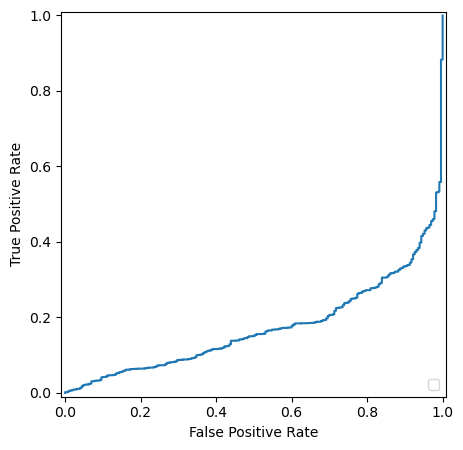

In [13]:
tpr, fpr, tresh = roc_curve(y_test, model.predict_proba(X_test)[:,1])
RocCurveDisplay(tpr=tpr, fpr=fpr).plot()

In [14]:
auc(tpr, fpr)

0.8282399901744043

**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [15]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

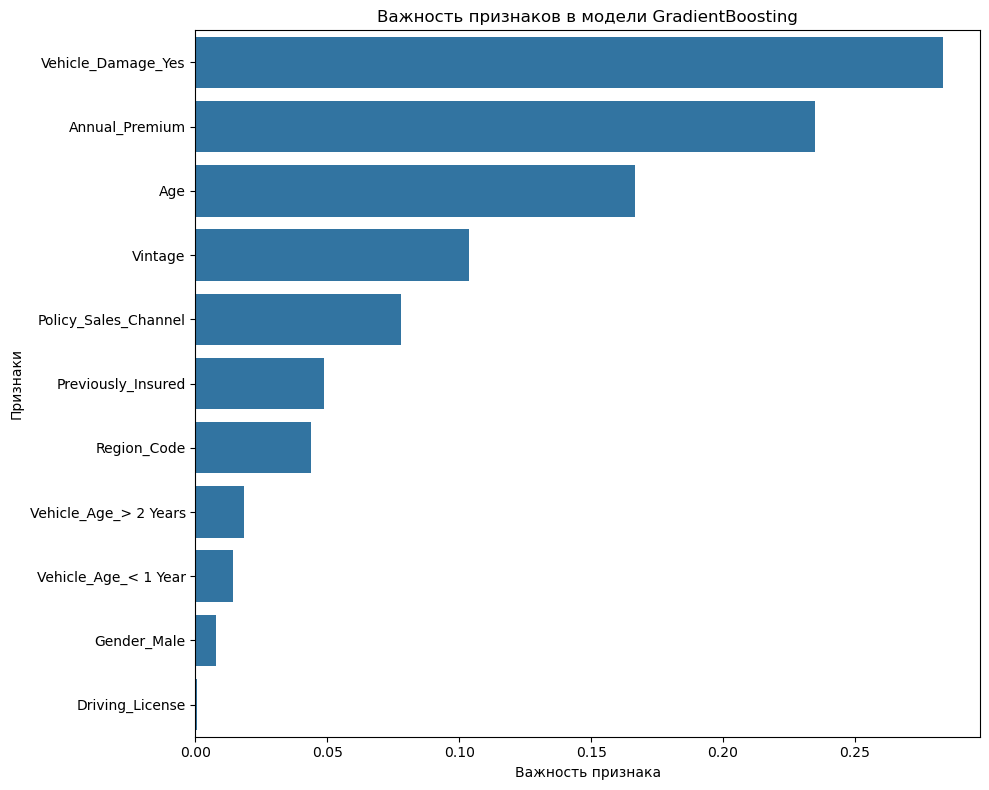

1.00      0.10      0.01
5     0.831627  0.830759  0.831008
10    0.838842  0.830759  0.831008
20    0.841775  0.830759  0.831008
50    0.841602  0.830759  0.831008
100   0.842926  0.831971  0.830759
200   0.840530  0.835457  0.830759
700   0.842988  0.845212  0.830510
1000  0.841267  0.844480  0.831464

In [16]:
### Your code is here

f1_matrix = np.zeros((len(n_estimators_list), len(learning_rate_list)))

for i, n_estimators in enumerate(n_estimators_list):
    for j, learning_rate in enumerate(learning_rate_list):
        model = GradientBoostingClassifier(learning_rate = learning_rate,
                                  random_state = 1,
                                  n_estimators = n_estimators)

        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_matrix[i,j] = f1

        if round(f1, 3) == 0.844:
            importance_gb = model.feature_importances_

            important_features_df = pd.DataFrame({
                'importance': importance_gb,
                'features': X.columns
            }).sort_values(by='importance', ascending=False)
            
            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='features', data=important_features_df)
            plt.title('Важность признаков в модели GradientBoosting')
            plt.xlabel('Важность признака')
            plt.ylabel('Признаки')
            plt.tight_layout()
            plt.show()

f1_df = pd.DataFrame(f1_matrix, index=n_estimators_list, columns=learning_rate_list)
f1_df

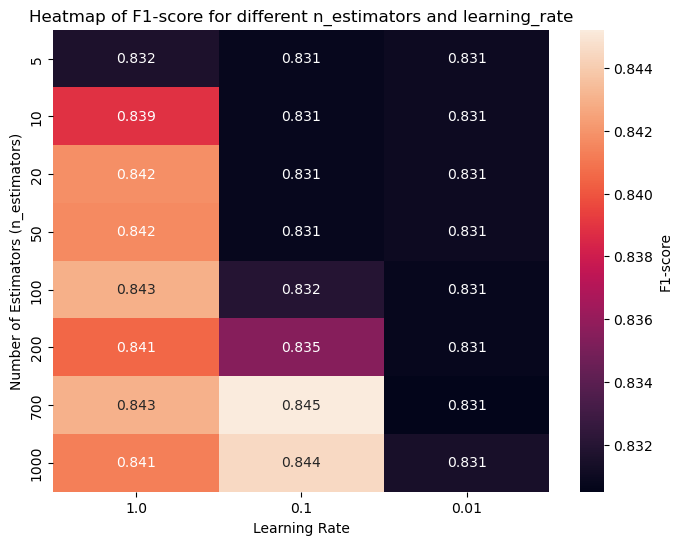

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(f1_df, annot=True, fmt='.3f', cbar_kws={'label': 'F1-score'})
plt.title('Heatmap of F1-score for different n_estimators and learning_rate')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Estimators (n_estimators)')
plt.show()

In [18]:
best_params = np.unravel_index(np.argmax(f1_matrix), f1_matrix.shape) #многомерный индекс
best_n_estimators = n_estimators_list[best_params[0]]
best_learning_rate = learning_rate_list[best_params[1]]

print(f"Максимальный F1-скор {round(f1_matrix[best_params], 3)} достигнут при n_estimators={best_n_estimators}, learning_rate={best_learning_rate}")

Максимальный F1-скор 0.845 достигнут при n_estimators=700, learning_rate=0.1


**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [19]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

### Your code is here

max_depth_list = [5, 5000]

results_train = {}
results_test = {}

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        
        model_rf = RandomForestClassifier(max_depth=max_depth,
                                          random_state = 1,
                                        n_estimators=n_estimators)

        model_rf.fit(X_train, y_train)
        
        y_pred_train = model_rf.predict(X_train)
        y_pred_test = model_rf.predict(X_test)
        
        train_score = f1_score(y_train, y_pred_train, average='weighted')
        test_score = f1_score(y_test, y_pred_test, average='weighted')

        print(f'n_estimators={n_estimators}, max_depth={max_depth}, train_score={train_score}, test_score={test_score}')

        if n_estimators not in results_train:
            results_train[n_estimators] = {}
            results_test[n_estimators] = {}

        results_train[n_estimators][max_depth] = train_score
        results_test[n_estimators][max_depth] = test_score
    
    

n_estimators=2, max_depth=5, train_score=0.8160242103159332, test_score=0.8343693233656059
n_estimators=2, max_depth=5000, train_score=0.9351134178894275, test_score=0.8470935948810975
n_estimators=3, max_depth=5, train_score=0.8149520969909199, test_score=0.8326586420276342
n_estimators=3, max_depth=5000, train_score=0.9652972163368871, test_score=0.8422991352295769
n_estimators=4, max_depth=5, train_score=0.813930988568076, test_score=0.830758821968692
n_estimators=4, max_depth=5000, train_score=0.9614873753535929, test_score=0.8413314107027893
n_estimators=5, max_depth=5, train_score=0.8147138885195815, test_score=0.8331741427417452
n_estimators=5, max_depth=5000, train_score=0.9802969543304672, test_score=0.839270329391933
n_estimators=10, max_depth=5, train_score=0.813626927184142, test_score=0.8310079575596817
n_estimators=10, max_depth=5000, train_score=0.9858057419544917, test_score=0.8414450820978798
n_estimators=20, max_depth=5, train_score=0.813626927184142, test_score=0.831

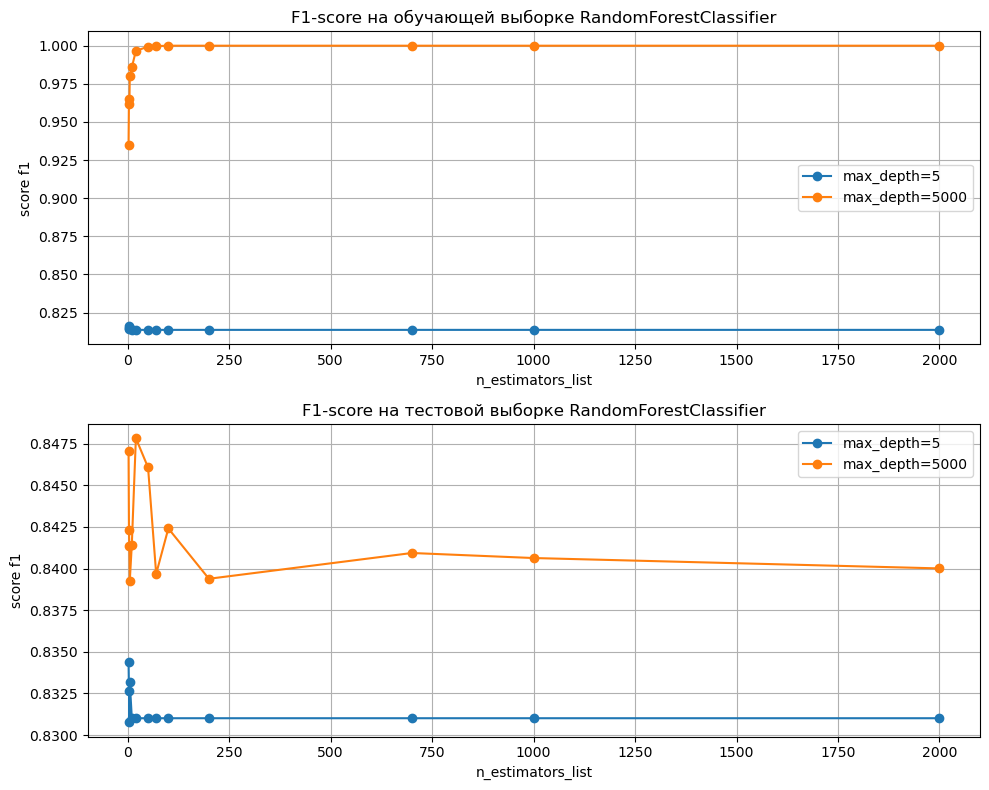

In [20]:

plt.figure(figsize=(10, 8))


for max_depth in max_depth_list:
    train_score = [results_train[n][max_depth] for n in n_estimators_list]
    test_score = [results_test[n][max_depth] for n in n_estimators_list]
    
    plt.subplot(2, 1, 1)
    plt.plot(n_estimators_list, train_score, label=f"max_depth={max_depth}", marker='o')
    plt.title("F1-score на обучающей выборке RandomForestClassifier")
    plt.xlabel('n_estimators_list')
    plt.ylabel('score f1')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(n_estimators_list, test_score, label=f'max_depth={max_depth}', marker='o')
    plt.title('F1-score на тестовой выборке RandomForestClassifier')
    plt.xlabel('n_estimators_list')
    plt.ylabel('score f1')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [21]:

### Your code is here

results_train = {}
results_test = {}

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        
        model_gb = GradientBoostingClassifier(max_depth=max_depth,
                                          random_state = 1,
                                        n_estimators=n_estimators)

        model_gb.fit(X_train, y_train)
        
        y_pred_train = model_gb.predict(X_train)
        y_pred_test = model_gb.predict(X_test)
        
        train_score = f1_score(y_train, y_pred_train, average='weighted')
        test_score = f1_score(y_test, y_pred_test, average='weighted')

        print(f'n_estimators={n_estimators}, max_depth={max_depth}, train_score={train_score}, test_score={test_score}')

        if n_estimators not in results_train:
            results_train[n_estimators] = {}
            results_test[n_estimators] = {}

        results_train[n_estimators][max_depth] = train_score
        results_test[n_estimators][max_depth] = test_score

n_estimators=2, max_depth=5, train_score=0.813626927184142, test_score=0.8310079575596817
n_estimators=2, max_depth=5000, train_score=0.813626927184142, test_score=0.8310079575596817
n_estimators=3, max_depth=5, train_score=0.813626927184142, test_score=0.8310079575596817
n_estimators=3, max_depth=5000, train_score=0.813626927184142, test_score=0.8310079575596817
n_estimators=4, max_depth=5, train_score=0.813626927184142, test_score=0.8322241135533787
n_estimators=4, max_depth=5000, train_score=0.813626927184142, test_score=0.8310079575596817
n_estimators=5, max_depth=5, train_score=0.8142345670069886, test_score=0.8319706786734021
n_estimators=5, max_depth=5000, train_score=1.0, test_score=0.8340129162973281
n_estimators=10, max_depth=5, train_score=0.8157452653412125, test_score=0.8319706786734021
n_estimators=10, max_depth=5000, train_score=1.0, test_score=0.8330625830167115
n_estimators=20, max_depth=5, train_score=0.8184347539579007, test_score=0.8317171483552104
n_estimators=20, 

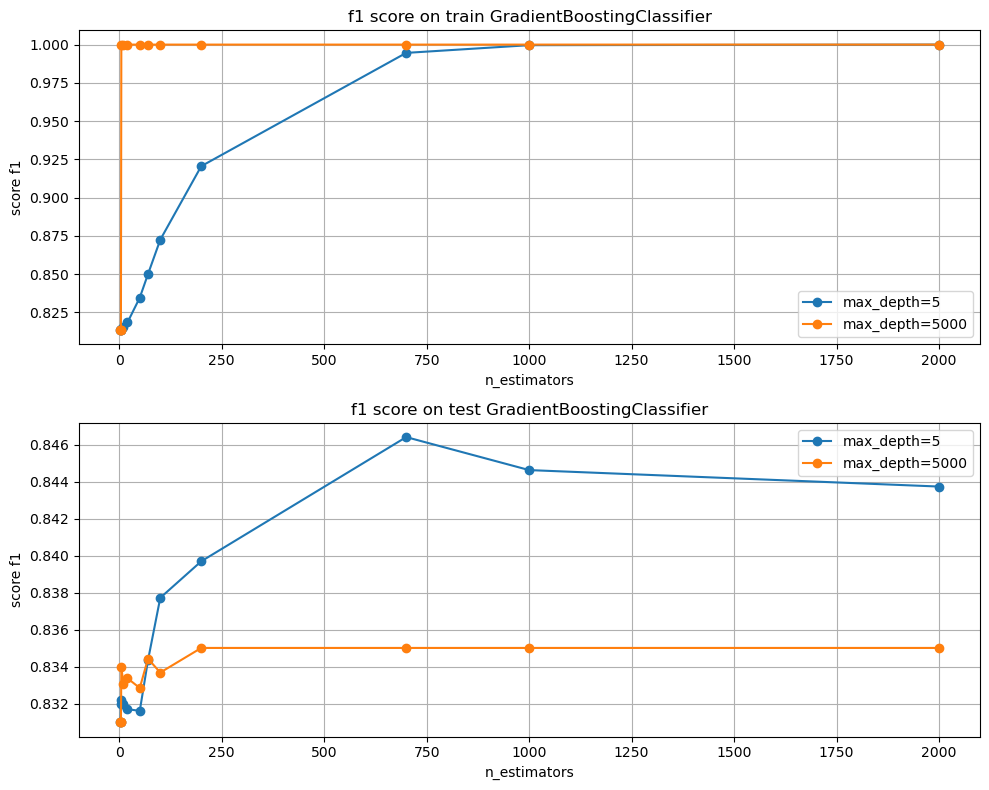

In [22]:
plt.figure(figsize=(10, 8))

for max_depth in max_depth_list:

    train_score = [results_train[n][max_depth] for n in n_estimators_list]
    test_score = [results_test[n][max_depth] for n in n_estimators_list]

    plt.subplot(2, 1, 1)
    plt.plot(n_estimators_list, train_score, label=f"max_depth={max_depth}", marker='o')
    plt.title('f1 score on train GradientBoostingClassifier')
    plt.xlabel('n_estimators')
    plt.ylabel('score f1')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(n_estimators_list, test_score, label=f"max_depth={max_depth}", marker='o')
    plt.title('f1 score on test GradientBoostingClassifier')
    plt.xlabel('n_estimators')
    plt.ylabel('score f1')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [23]:
X = data_catboost.drop('Response', axis=1)
y = data_catboost['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [24]:
from catboost import CatBoostClassifier
### Your code is here

cat_features = [col for col in X.select_dtypes(include=['object']).columns]

model_cb =  CatBoostClassifier(random_state=1)

model_cb.fit(X_train, y_train, cat_features=cat_features)

y_pred_test = model_cb.predict(X_test)

f1_test_score = f1_score(y_test, y_pred_test, average='weighted')

print(f'F1-score на тестовой выборке: {f1_test_score}')

Learning rate set to 0.025035
0:	learn: 0.6585225	total: 64.1ms	remaining: 1m 4s
1:	learn: 0.6268982	total: 67.3ms	remaining: 33.6s
2:	learn: 0.5928588	total: 70.9ms	remaining: 23.6s
3:	learn: 0.5650766	total: 73.9ms	remaining: 18.4s
4:	learn: 0.5422486	total: 77.1ms	remaining: 15.3s
5:	learn: 0.5180757	total: 80.3ms	remaining: 13.3s
6:	learn: 0.4967701	total: 83.6ms	remaining: 11.9s
7:	learn: 0.4783631	total: 86.7ms	remaining: 10.7s
8:	learn: 0.4615549	total: 90.1ms	remaining: 9.93s
9:	learn: 0.4527304	total: 93.4ms	remaining: 9.24s
10:	learn: 0.4445958	total: 96.6ms	remaining: 8.69s
11:	learn: 0.4300633	total: 99.8ms	remaining: 8.22s
12:	learn: 0.4153701	total: 103ms	remaining: 7.83s
13:	learn: 0.4046506	total: 106ms	remaining: 7.5s
14:	learn: 0.3953227	total: 110ms	remaining: 7.19s
15:	learn: 0.3908375	total: 114ms	remaining: 6.98s
16:	learn: 0.3866243	total: 117ms	remaining: 6.76s
17:	learn: 0.3780907	total: 120ms	remaining: 6.55s
18:	learn: 0.3711807	total: 123ms	remaining: 6.37s


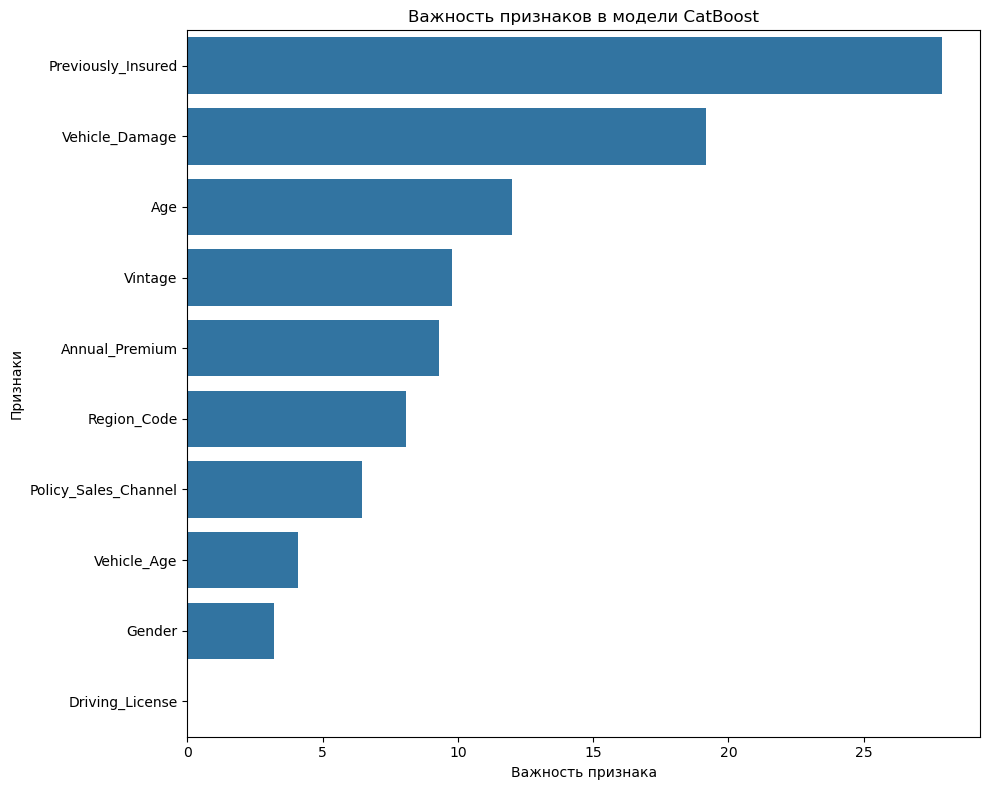

In [25]:
importance = model_cb.get_feature_importance()

important_features_df = pd.DataFrame({
    'importance': importance,
    'feature': X.columns
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=important_features_df)
plt.title('Важность признаков в модели CatBoost')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

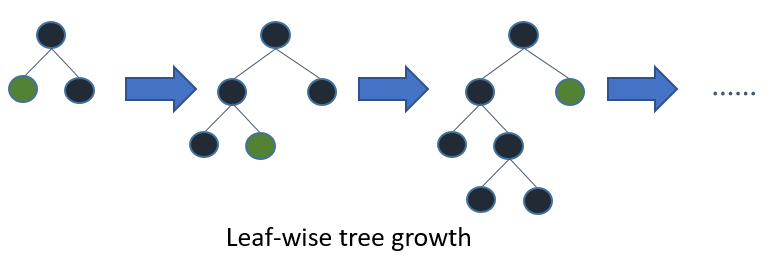

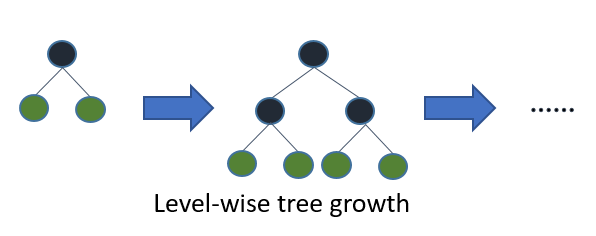

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [26]:
X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

### Your code is here


search = GridSearchCV(LGBMClassifier(random_state=1),
                     params)

search.fit(X_train, y_train)

best_params = search.best_params_
print(f'Best params : {best_params}')

best_estimator = search.best_estimator_
y_test_pred = best_estimator.predict(X_test)

print(classification_report(y_test, y_test_pred))



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 814, number of negative: 5586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127188 -> initscore=-1.926058
[LightGBM] [Info] Start training from score -1.926058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai